# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

## Common setup

In [108]:
%load_ext autoreload
%autoreload 2

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit, fgsm_attack
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline

import faiss

from torchvision.datasets import MNIST
from datasets import SiameseMNIST
from datasets import TripletMNIST
from torchvision import transforms

# Set up the network and training parameters
from networks import EmbeddingNetX, ClassificationNetX, SiameseNet, TripletNet
from metrics import AccumulatedAccuracyMetric
from losses import ContrastiveLoss, TripletLoss

from utils import set_grad, extract_embeddingsx,plot_embeddings, show_statistics, reduce_dimension

# from luna import set_seed

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
#                                  transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
#                                 transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

def train_metric_net(embedding_net):
    set_grad(embedding_net, False)
    model = ClassificationNetX(embedding_net, n_classes=n_classes)
    if cuda:
        model.cuda()

    fit(train_loader, 
        test_loader, 
        model, 
        loss_fn = torch.nn.NLLLoss(), 
        optimizer = optim.Adam(model.parameters(), lr=1e-2), 
#         scheduler = lr_scheduler.StepLR(optimizer, 4, gamma=0.1, last_epoch=-1), 
        scheduler = None,
        n_epochs = 5, 
        cuda = cuda, 
        log_interval = 10000, 
        metrics = [AccumulatedAccuracyMetric()])
    set_grad(embedding_net, True)
    return model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [199]:
base_model = ClassificationNetX(EmbeddingNetX(), n_classes=n_classes)
if cuda:
    base_model.cuda()
    
fit(train_loader, 
    test_loader, 
    base_model, 
    loss_fn = torch.nn.NLLLoss(), 
    optimizer = optim.Adam(base_model.parameters(), lr = 1e-2), 
#     scheduler = lr_scheduler.StepLR(optimizer, 4, gamma=0.1, last_epoch=-1), 
    scheduler = None,
    n_epochs = 10, 
    cuda = cuda,
    log_interval = 10000,
    metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.314540	Accuracy: 9.765625
Epoch: 1/10. Train set: Average loss: 0.2696	Accuracy: 91.44
Epoch: 1/10. Validation set: Average loss: 0.0546	Accuracy: 98.3
Train: [0/60000 (0%)]	Loss: 0.051102	Accuracy: 97.65625
Epoch: 2/10. Train set: Average loss: 0.0515	Accuracy: 98.50333333333333
Epoch: 2/10. Validation set: Average loss: 0.0473	Accuracy: 98.64
Train: [0/60000 (0%)]	Loss: 0.072900	Accuracy: 98.046875
Epoch: 3/10. Train set: Average loss: 0.0424	Accuracy: 98.81333333333333
Epoch: 3/10. Validation set: Average loss: 0.0424	Accuracy: 98.82
Train: [0/60000 (0%)]	Loss: 0.041052	Accuracy: 98.828125
Epoch: 4/10. Train set: Average loss: 0.0366	Accuracy: 98.91166666666666
Epoch: 4/10. Validation set: Average loss: 0.0451	Accuracy: 98.67
Train: [0/60000 (0%)]	Loss: 0.035998	Accuracy: 98.828125
Epoch: 5/10. Train set: Average loss: 0.0332	Accuracy: 99.10833333333333
Epoch: 5/10. Validation set: Average loss: 0.0613	Accuracy: 98.15
Train: [0/60000 (0%)]	Loss: 0.04488

In [21]:
show_statistics(test_loader, base_model)

all median: 39.10
inner 1%: 4.28, 10%: 6.47, 90%: 17.55, 99%: 26.69, std: 4.67
intra 1: 37.46, 2: 40.22, 3: 41.76, std: 16.07
inner: 10.53, intra: 45.06, intra/inner: 4.28


In [188]:
_, metric = fgsm_attack(0.3, test_loader, base_model, torch.nn.NLLLoss(), cuda, [AccumulatedAccuracyMetric()])
metric[0].value()

23.61

In [207]:
# train_embeddings_baseline, train_labels_baseline = extract_embeddingsx(train_loader, model)
# plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings, val_labels = extract_embeddingsx(test_loader, base_model)
# raw_2d = reduce_dimension(val_embeddings, 'pca')
# plot_embeddings(raw_2d, val_labels)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [176]:
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
siam_embedding_net = EmbeddingNetX()
siam_net = SiameseNet(siam_embedding_net)
if cuda:
    siam_net.cuda()
    
print('Fit a siamese net')
fit(siamese_train_loader, 
    siamese_test_loader, 
    siam_net, 
    loss_fn = ContrastiveLoss(1.), 
    optimizer = optim.Adam(siam_net.parameters(), lr=1e-3), 
#     scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1), 
    scheduler = None,
    n_epochs = 10, 
    cuda = cuda,  
    log_interval = 10000)

print('Fit a siamese classifier')
siam_model = train_metric_net(siam_embedding_net)

Fit a siamese net
Train: [0/60000 (0%)]	Loss: 0.247498
Epoch: 1/10. Train set: Average loss: 0.0260
Epoch: 1/10. Validation set: Average loss: 0.0088
Train: [0/60000 (0%)]	Loss: 0.016079
Epoch: 2/10. Train set: Average loss: 0.0066
Epoch: 2/10. Validation set: Average loss: 0.0048
Train: [0/60000 (0%)]	Loss: 0.006403
Epoch: 3/10. Train set: Average loss: 0.0037
Epoch: 3/10. Validation set: Average loss: 0.0035
Train: [0/60000 (0%)]	Loss: 0.000725
Epoch: 4/10. Train set: Average loss: 0.0025
Epoch: 4/10. Validation set: Average loss: 0.0031
Train: [0/60000 (0%)]	Loss: 0.001892
Epoch: 5/10. Train set: Average loss: 0.0019
Epoch: 5/10. Validation set: Average loss: 0.0038
Train: [0/60000 (0%)]	Loss: 0.004797
Epoch: 6/10. Train set: Average loss: 0.0015
Epoch: 6/10. Validation set: Average loss: 0.0032
Train: [0/60000 (0%)]	Loss: 0.000488
Epoch: 7/10. Train set: Average loss: 0.0011
Epoch: 7/10. Validation set: Average loss: 0.0039
Train: [0/60000 (0%)]	Loss: 0.001546
Epoch: 8/10. Train se

In [117]:
# train_embeddings_cl, train_labels_cl = extract_embeddingsx(train_loader, model)
# plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings, val_labels = extract_embeddingsx(test_loader, siam_model)
raw_2d = reduce_dimension(val_embeddings, 'tsne')
# plot_embeddings(raw_2d, val_labels)

Iteration   50, KL divergence  4.2962, 50 iterations in 2.0899 sec
Iteration  100, KL divergence  3.6890, 50 iterations in 1.8744 sec
Iteration  150, KL divergence  3.5017, 50 iterations in 2.5401 sec
Iteration  200, KL divergence  3.4128, 50 iterations in 1.8851 sec
Iteration  250, KL divergence  3.3581, 50 iterations in 1.8028 sec
Iteration   50, KL divergence  2.5828, 50 iterations in 1.8413 sec
Iteration  100, KL divergence  2.2578, 50 iterations in 2.1238 sec
Iteration  150, KL divergence  2.0316, 50 iterations in 1.9247 sec
Iteration  200, KL divergence  1.8735, 50 iterations in 1.7915 sec
Iteration  250, KL divergence  1.7577, 50 iterations in 2.2681 sec
Iteration  300, KL divergence  1.6696, 50 iterations in 2.0317 sec
Iteration  350, KL divergence  1.5999, 50 iterations in 1.9589 sec
Iteration  400, KL divergence  1.5432, 50 iterations in 2.1991 sec
Iteration  450, KL divergence  1.4965, 50 iterations in 2.2408 sec
Iteration  500, KL divergence  1.4574, 50 iterations in 2.0365

In [87]:
show_statistics(test_loader, siam_model)

all median: 1.14
inner 1%: 0.01, 10%: 0.01, 90%: 0.03, 99%: 0.57, std: 0.10
intra 1: 1.30, 2: 1.37, 3: 1.40, std: 0.55
inner: 0.02, intra: 1.44, intra/inner: 88.34


In [206]:
# siam_model = train_metric_net(siam_embedding_net)
adv_reprs, metric = fgsm_attack(0.3, test_loader, base_model, torch.nn.NLLLoss(), cuda, [AccumulatedAccuracyMetric()])
metric[0].value()

55.71

In [201]:
# val_embeddings.shape
cat_reprs = np.concatenate([val_embeddings, adv_reprs])
cat_2d = reduce_dimension(cat_reprs, 'tsne')
# adv_2d = reduce_dimension(adv_reprs, "tsne")
# plot_embeddings(adv_2d, val_labels_cl)

Iteration   50, KL divergence  6.0937, 50 iterations in 3.3976 sec
Iteration  100, KL divergence  4.6958, 50 iterations in 4.1721 sec
Iteration  150, KL divergence  4.1433, 50 iterations in 3.5724 sec
Iteration  200, KL divergence  3.9257, 50 iterations in 3.4895 sec
Iteration  250, KL divergence  3.8040, 50 iterations in 3.6829 sec
Iteration   50, KL divergence  3.1284, 50 iterations in 3.8263 sec
Iteration  100, KL divergence  2.7829, 50 iterations in 4.1410 sec
Iteration  150, KL divergence  2.5361, 50 iterations in 4.6471 sec
Iteration  200, KL divergence  2.3524, 50 iterations in 3.3969 sec
Iteration  250, KL divergence  2.2100, 50 iterations in 3.6626 sec
Iteration  300, KL divergence  2.0960, 50 iterations in 3.1935 sec
Iteration  350, KL divergence  2.0025, 50 iterations in 3.5397 sec
Iteration  400, KL divergence  1.9242, 50 iterations in 3.2248 sec
Iteration  450, KL divergence  1.8576, 50 iterations in 4.0434 sec
Iteration  500, KL divergence  1.8001, 50 iterations in 3.3691

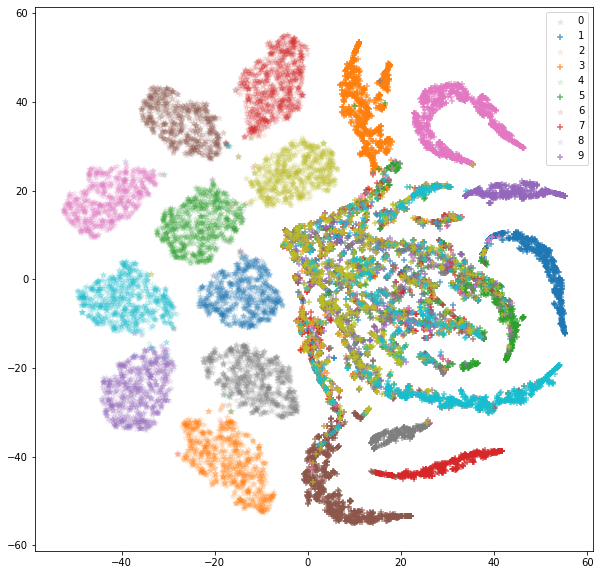

In [202]:
from utils import plot_embeddings_v2
plot_embeddings_v2(cat_2d, val_labels_cl)

# plot_embeddings(cat_2d[:10000], val_labels_cl)
# plot_embeddings(cat_2d[10000:], val_labels_cl)


In [210]:
train_embeddings, train_labels = extract_embeddingsx(train_loader, base_model, 'none')
index = faiss.IndexFlatL2(32)
res = faiss.StandardGpuResources()  # use a single GPU
index = faiss.index_cpu_to_gpu(res, 0, index)
index.add(train_embeddings.astype(np.float32))

In [213]:
# knn_reprs = val_embeddings
knn_reprs = adv_reprs

for k in [1, 2, 4, 8, 16, 32, 64]:
    D, I = index.search(knn_reprs.astype(np.float32), k=k)
    from scipy import stats
    knn_preds = stats.mode(train_labels[I], axis=1).mode.reshape(-1)
    accu = sum(knn_preds == test_dataset.targets.numpy()) / len(test_dataset) * 100
    print("{:.2f}, {}".format(accu, D.mean()))


45.87, 889869.125
45.98, 890743.5
45.90, 892126.3125
46.02, 893665.0625
45.88, 895321.0
45.84, 897183.5625
45.87, 899532.875


In [215]:
# D, I = index.search(adv_reprs.astype(np.float32), k=3)
# D[:, 1].mean()
adv_reprs[0]

array([ -66.01306 ,  -90.94975 ,  -16.795486,  -22.803589, -237.50429 ,
       -116.433914, -108.08066 ,  -45.1676  ,  -23.093176,  -33.327587,
        -58.75008 , -118.98472 ,   27.0563  ,  -52.147236,  -52.287354,
       -318.88693 , -116.42319 ,  -82.10932 ,  -40.664684, -244.53015 ,
        -47.870773,  -54.776108,  -40.88106 , -103.33977 ,  -94.11348 ,
        -43.887913,  -88.22329 ,  -36.82554 , -167.94691 , -113.43533 ,
       -381.11093 , -216.64427 ], dtype=float32)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [6]:
triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters

margin = 1.
embedding_net = EmbeddingNetX()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 100

In [7]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.998572
Train: [12800/60000 (21%)]	Loss: 0.209274
Train: [25600/60000 (43%)]	Loss: 0.055866
Train: [38400/60000 (64%)]	Loss: 0.042741
Train: [51200/60000 (85%)]	Loss: 0.031640
Epoch: 1/10. Train set: Average loss: 0.0784
Epoch: 1/10. Validation set: Average loss: 0.0201
Train: [0/60000 (0%)]	Loss: 0.043787
Train: [12800/60000 (21%)]	Loss: 0.020606
Train: [25600/60000 (43%)]	Loss: 0.020210
Train: [38400/60000 (64%)]	Loss: 0.024579
Train: [51200/60000 (85%)]	Loss: 0.017155
Epoch: 2/10. Train set: Average loss: 0.0204
Epoch: 2/10. Validation set: Average loss: 0.0174
Train: [0/60000 (0%)]	Loss: 0.004140
Train: [12800/60000 (21%)]	Loss: 0.015223
Train: [25600/60000 (43%)]	Loss: 0.016596
Train: [38400/60000 (64%)]	Loss: 0.016560
Train: [51200/60000 (85%)]	Loss: 0.014566
Epoch: 3/10. Train set: Average loss: 0.0155
Epoch: 3/10. Validation set: Average loss: 0.0127
Train: [0/60000 (0%)]	Loss: 0.012973
Train: [12800/60000 (21%)]	Loss: 0.011402
Train: [25600/60000 (

Iteration   50, KL divergence  4.3481, 50 iterations in 1.3892 sec
Iteration  100, KL divergence  3.7583, 50 iterations in 1.1908 sec
Iteration  150, KL divergence  3.5938, 50 iterations in 1.2179 sec
Iteration  200, KL divergence  3.5160, 50 iterations in 1.5037 sec
Iteration  250, KL divergence  3.4684, 50 iterations in 1.2665 sec
Iteration   50, KL divergence  2.7058, 50 iterations in 1.2553 sec
Iteration  100, KL divergence  2.3873, 50 iterations in 1.3267 sec
Iteration  150, KL divergence  2.1685, 50 iterations in 1.1733 sec
Iteration  200, KL divergence  2.0149, 50 iterations in 1.5078 sec
Iteration  250, KL divergence  1.9030, 50 iterations in 1.4478 sec
Iteration  300, KL divergence  1.8172, 50 iterations in 1.1492 sec
Iteration  350, KL divergence  1.7492, 50 iterations in 1.0231 sec
Iteration  400, KL divergence  1.6938, 50 iterations in 1.3836 sec
Iteration  450, KL divergence  1.6478, 50 iterations in 1.3050 sec
Iteration  500, KL divergence  1.6090, 50 iterations in 1.2032

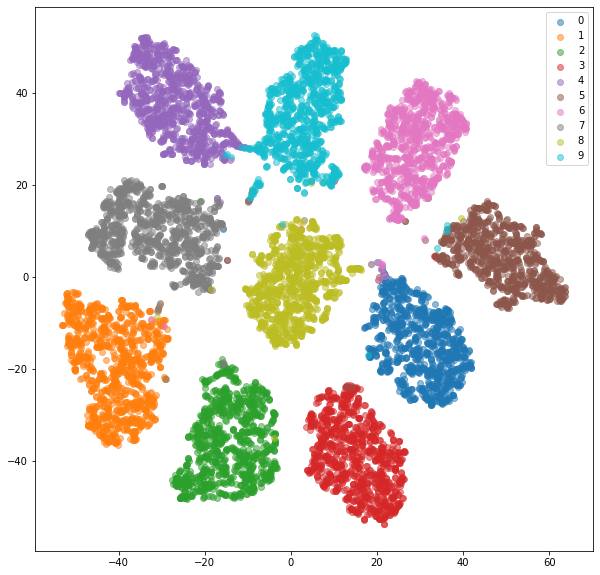

In [12]:
# train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
# plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddingsx(test_loader, model, 'tsne')
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNetX
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNetX()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
# train_embeddings_ocl, train_labels_ocl = extract_embeddingsx(train_loader, model)
# plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddingsx(test_loader, model, 'tsne')
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)